# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

In [ ]:
'''
Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs
Steps :
1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

"\nExperimenting with Multi-Class Sequence Classification using RNNs and LSTMs\nSteps :\n1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.\n2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:\n  -   Adapt the classification loss and the SequenceClassifier module\n  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix\n3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.\n4. Visualize analyse and discuss the results in the report.\n"

Mounted at /content/drive
Train Seqs: (210, 40)
Train Labels: (210,)
Test Seqs: (90, 40)
Test Labels: (90,)


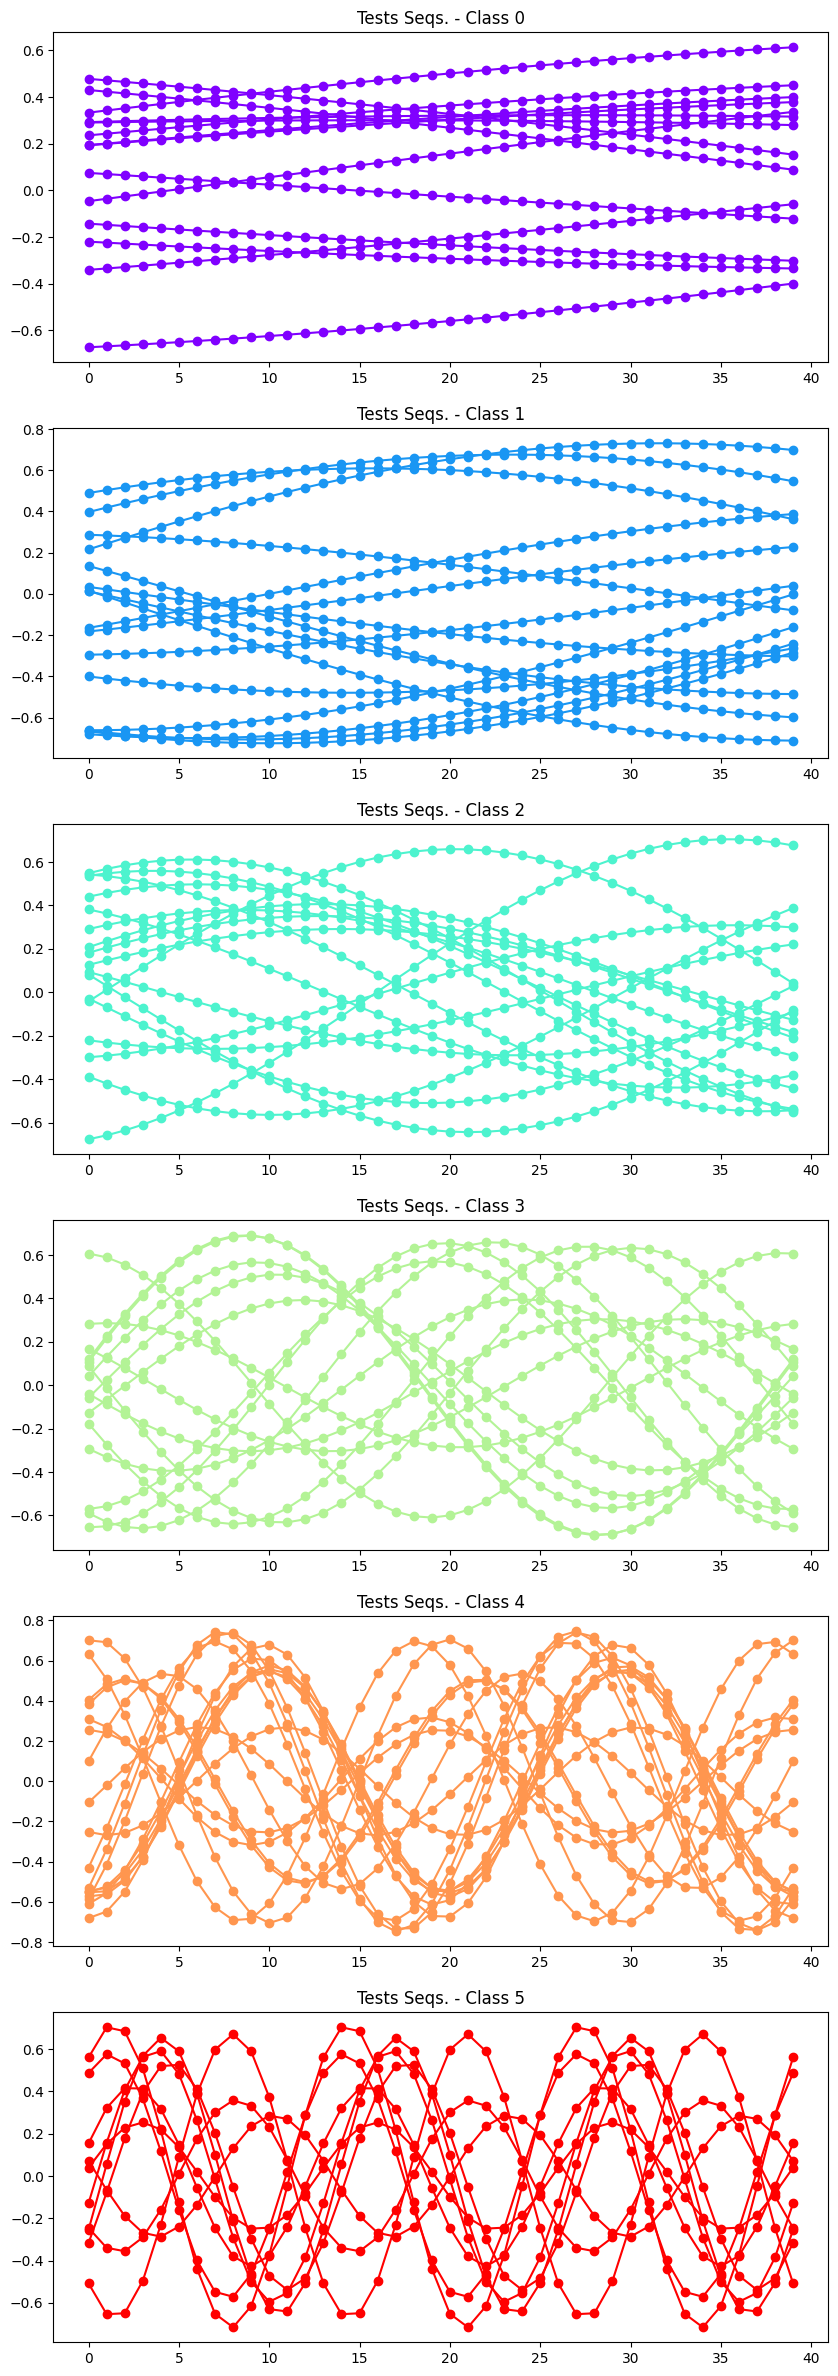

In [ ]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt

drive.mount('/content/drive')
#myDrive = '/content/drive/My Drive/DeepLearning_2023/P2/Data/'


myDrive= '/content/drive/My Drive/Curs 2022-2023/Deep Learning/P2/Data/'
file_path = os.path.join(myDrive,'P2_E1.npz') 
data = np.load(file_path )
X_train, X_test = data['X_train'],data['X_test'] 
Y_train, Y_test = data['Y_train'],data['Y_test']

print(f'Train Seqs: {X_train.shape}')
print(f'Train Labels: {Y_train.shape}')
print(f'Test Seqs: {X_test.shape}')
print(f'Test Labels: {Y_test.shape}')

classes = np.unique(Y_train)
n_classes = len(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig, axs = plt.subplots(n_classes,1, figsize=(10, 5*n_classes))
for class_idx in range(0,n_classes):
  axs[class_idx].plot(X_test[Y_test==class_idx,:].T,'-o',
                      c=colors[class_idx])
  axs[class_idx].set_title(f'Tests Seqs. - Class {class_idx}')
fig.show()


#Sol 1. 

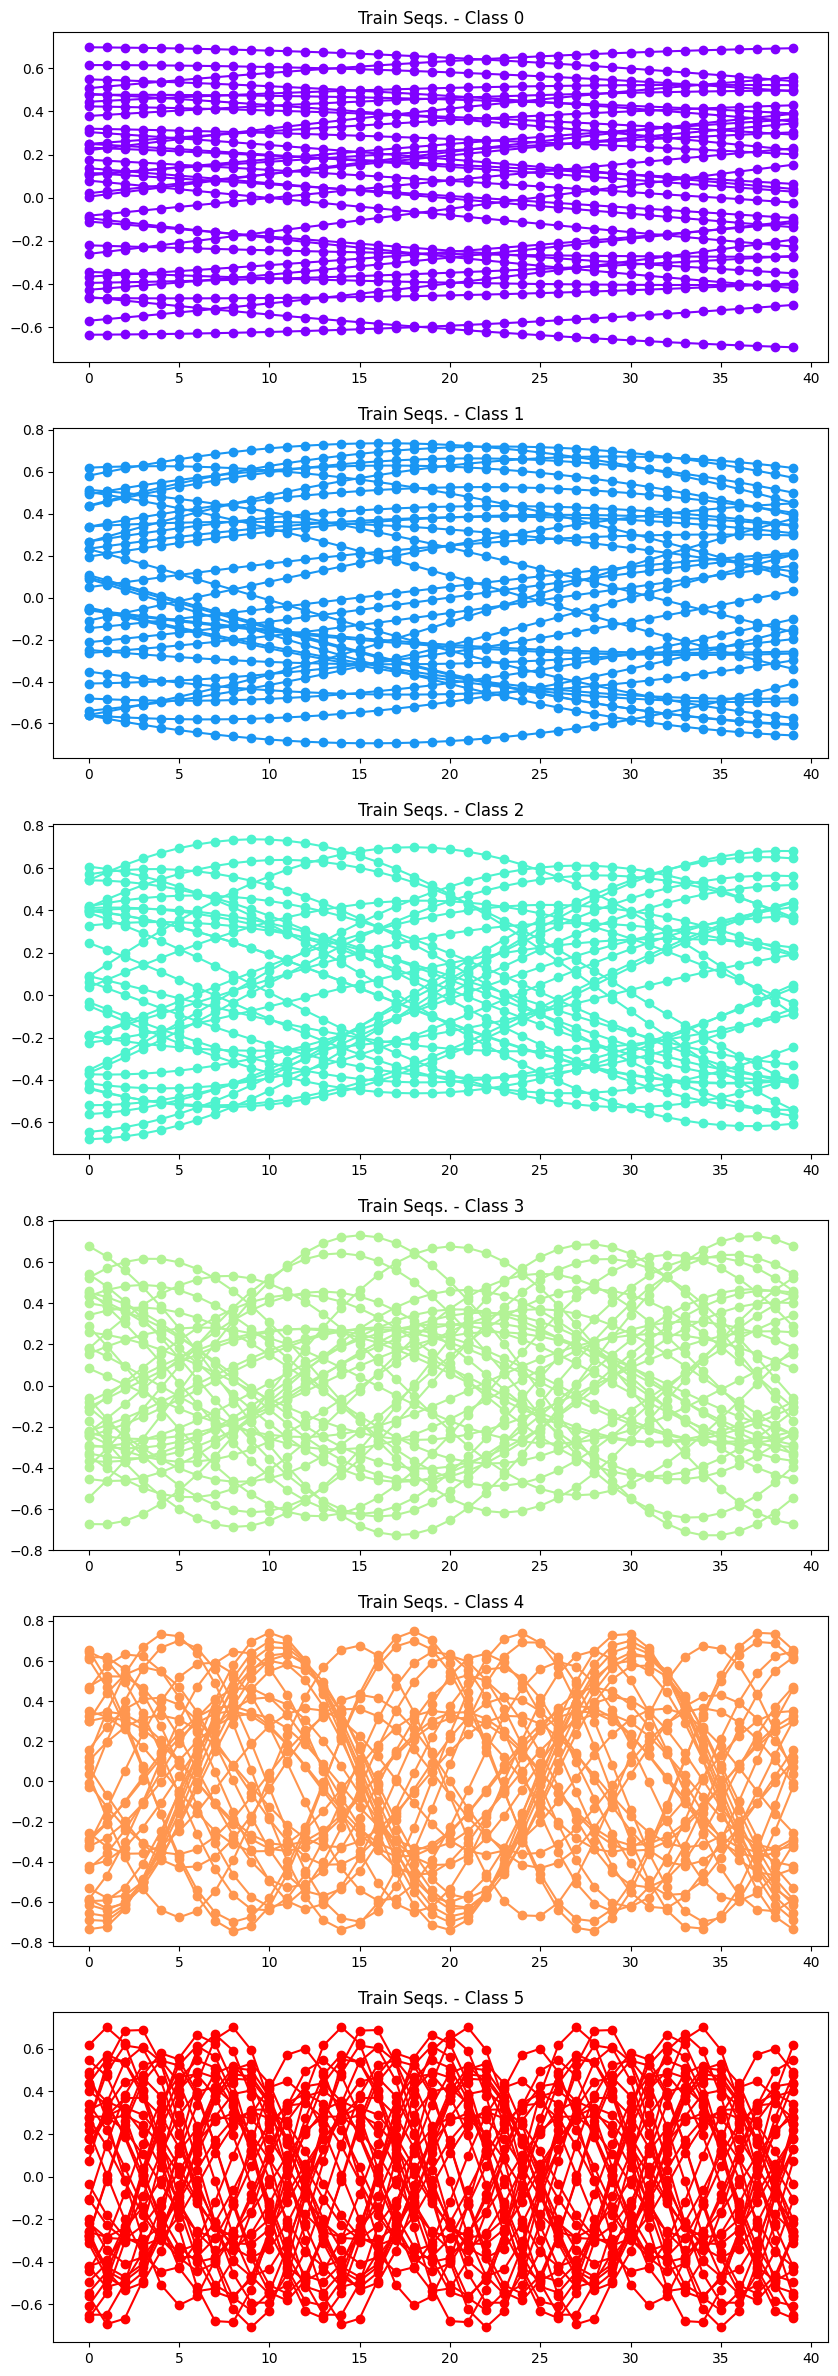

In [ ]:
#Visualize the Train Data
fig, axs = plt.subplots(n_classes,1, figsize=(10, 5*n_classes))
for class_idx in range(0,n_classes):
  axs[class_idx].plot(X_train[Y_train==class_idx,:].T,'-o',
                      c=colors[class_idx])
  axs[class_idx].set_title(f'Train Seqs. - Class {class_idx}')
fig.show()


In [ ]:
from torch.nn.modules import activation
import torch
from torch import nn

# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class SequenceClassifier(nn.Module):
  def __init__(self,
               input_size : int = 1, 
               hidden_size : int = 5, 
               num_layers = 1,
               use_lstm : bool = False):
    # Define RNN or LSTM architecture
    super().__init__()
    self.use_lstm = use_lstm
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                          num_layers=num_layers, batch_first = True)
    else:
      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size, 
                         num_layers=num_layers, batch_first = True)
    self.last_linear = nn.Linear(hidden_size,n_classes) #For multi-class we are going to use as units as classes instead of 1 as for binary

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    if(not self.use_lstm):
      last_hidden_state = last_states[-1,:,:].squeeze(0)
    else:
      last_hidden_state = last_states[0][-1,:,:].squeeze(0)
    # Get sequence label probability using the last hidden state
    output = self.last_linear(last_hidden_state) 
    return output

In [ ]:
# Conduct Gradient Descent Optimization over the training dataset
def train_sequence_classifier(X_train, Y_train, seq_classifier, optimizer, loss_func, epochs=100):
    loss_its = [] 
    for iter in range(epochs):
      optimizer.zero_grad()
      output = seq_classifier(X_train)
      loss = loss_func(output, Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    final_loss = loss_func(seq_classifier(X_train), Y_train)
    print(f'Final loss: {final_loss.item()}')
    return np.asarray(loss_its)

In [ ]:
from sklearn.metrics import confusion_matrix
# Compute accuracy accross testing dataset
def test_sequence_classifier(X_test, Y_test, seq_classifier):
  output = seq_classifier(X_test)

  predicted_labels = torch.argmax(output, dim=1)
  correct_predictions = (predicted_labels == Y_test).sum().item()
  total_predictions = len(Y_test)
  accuracy = correct_predictions / total_predictions
  print(f'Test Accuracy: {accuracy}')

  # Compute confusion matrix
  num_classes = output.shape[1]
  confusion = torch.zeros(num_classes, num_classes, dtype=torch.int64)
  for true_label, predicted_label in zip(Y_test, predicted_labels):
    confusion[true_label, predicted_label] += 1

   # Compute the confusion matrix
  cm = confusion_matrix(Y_test.cpu().numpy(), predicted_labels.cpu().numpy())

  # Normalize the confusion matrix
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(n_classes)
  plt.xticks(tick_marks, range(n_classes))
  plt.yticks(tick_marks, range(n_classes))
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()
  return accuracy

In [ ]:
# Dataset to PyTorch format
X_train_pt = torch.from_numpy(X_train).float().unsqueeze(2).cuda()
Y_train_pt = torch.from_numpy(Y_train).long().cuda()
X_test_pt = torch.from_numpy(X_test).float().unsqueeze(2).cuda()
Y_test_pt = torch.from_numpy(Y_test).long().cuda()

# Define Binary Cross entr
loss_func = nn.CrossEntropyLoss()

In [ ]:
#FIRST ROUND
'''# Define the grid of hyperparameters
from itertools import product
exp_hidden_size = [10, 15, 20, 32, 50]
exp_num_layers = [3, 5, 6]
exp_learning_rate = [3e-3, 2e-3, 1e-3]
exp_epochs = [1000, 1500, 2000]
exp_use_lstm = [False, True]

# Define the list of optimizers to try
#exp_optimizers = [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.Adamax]
exp_optimizers = [torch.optim.RMSprop, torch.optim.Adam, torch.optim.Adamax]

# Perform grid search
best_accuracy = 0.0
best_model_id = ""
best_hidden_size = 0
best_num_layers = 0
best_use_lstm = False
best_learning_rate = 0.0
best_epochs = 0
best_optimizer = None

for hidden_size, num_layers, use_lstm, learning_rate, epochs, optimizer_class in product(exp_hidden_size, exp_num_layers, exp_use_lstm, exp_learning_rate, exp_epochs, exp_optimizers):
    model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}_LR{learning_rate}_E{epochs}'
    print(f'Training: {model_id}')
    seq_classifier = SequenceClassifier(use_lstm=use_lstm, num_layers=num_layers, hidden_size=hidden_size)
    seq_classifier.cuda()
    optimizer = optimizer_class(seq_classifier.parameters(), lr=learning_rate)
    losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=epochs)
    accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_id = model_id
        best_hidden_size = hidden_size
        best_num_layers = num_layers
        best_use_lstm = use_lstm
        best_learning_rate = learning_rate
        best_epochs = epochs
        best_optimizer = optimizer_class.__name__

print("Grid search complete.")
print(f"Best model: {best_model_id}")
print(f"Best hidden size: {best_hidden_size}")
print(f"Best number of layers: {best_num_layers}")
print(f"Best use_lstm: {best_use_lstm}")
print(f"Best learning rate: {best_learning_rate}")
print(f"Best epochs: {best_epochs}")
print(f"Best optimizer: {best_optimizer}")
print(f"Best accuracy: {best_accuracy}")'''

'# Define the grid of hyperparameters\nexp_hidden_size = [10, 15, 20, 32, 50]\nexp_num_layers = [3, 5, 6]\nexp_learning_rate = [3e-3, 2e-3, 1e-3]\nexp_epochs = [1000, 1500, 2000]\nexp_use_lstm = [False, True]\n\n# Define the list of optimizers to try\n#exp_optimizers = [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.Adamax]\nexp_optimizers = [torch.optim.RMSprop, torch.optim.Adam, torch.optim.Adamax]\n\n# Perform grid search\nbest_accuracy = 0.0\nbest_model_id = ""\nbest_hidden_size = 0\nbest_num_layers = 0\nbest_use_lstm = False\nbest_learning_rate = 0.0\nbest_epochs = 0\nbest_optimizer = None\n\nfor hidden_size, num_layers, use_lstm, learning_rate, epochs, optimizer_class in product(exp_hidden_size, exp_num_layers, exp_use_lstm, exp_learning_rate, exp_epochs, exp_optimizers):\n    model_id = f\'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}_LR{learning_rate}_E{epochs}\'\n    print(f\'Training: {model_id}\')\n    seq_classifier = SequenceClassifier(use_lstm=

In [ ]:
#SECOND ROUND
'''from itertools import product
# Define the grid of hyperparameters
exp_hidden_size = [15, 20, 32, 50]
exp_num_layers = [3, 5, 6]
exp_learning_rate = [3e-3, 2e-3, 1e-3]
N=10

# Define the list of optimizers to try
exp_optimizers = [torch.optim.RMSprop, torch.optim.Adam, torch.optim.Adamax]
# Perform grid search
best_accuracy = 0.0
best_model_id = ""
best_hidden_size = 0
best_num_layers = 0
best_learning_rate = 0.0
best_optimizer = None

for hidden_size, num_layers, learning_rate, optimizer_class in product(exp_hidden_size, exp_num_layers, exp_learning_rate, exp_optimizers):
  sum=0
  model_id = f'H{hidden_size}_NL{num_layers}_LR{learning_rate}_OPT{optimizer_class.__name__}'
  print(f'Training: {model_id}')
  for i in range(0,N):
    seq_classifier = SequenceClassifier(use_lstm=True, num_layers=num_layers, hidden_size=hidden_size)
    seq_classifier.cuda()
    optimizer = optimizer_class(seq_classifier.parameters(), lr=learning_rate)
    losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
    accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
    sum+=accuracy

  mean = sum/N
  print("Mean accuracy: ", mean)  
  if mean > best_accuracy:
    best_accuracy = mean
    best_model_id = model_id
    best_hidden_size = hidden_size
    best_num_layers = num_layers
    best_learning_rate = learning_rate
    best_optimizer = optimizer_class.__name__

print("Grid search complete.")
print(f"Best model: {best_model_id}")
print(f"Best hidden size: {best_hidden_size}")
print(f"Best number of layers: {best_num_layers}")
print(f"Best learning rate: {best_learning_rate}")
print(f"Best optimizer: {best_optimizer}")
print(f"Best accuracy: {best_accuracy}")'''

Training: H15_NL3_LR0.003_OPTRMSprop
Final loss: 1.0773506164550781
Test Accuracy: 0.9111111111111111
Final loss: 1.119816541671753
Test Accuracy: 0.8222222222222222
Final loss: 1.1944688558578491
Test Accuracy: 0.7777777777777778
Final loss: 1.1388723850250244
Test Accuracy: 0.7888888888888889
Final loss: 1.1091336011886597
Test Accuracy: 0.8888888888888888
Final loss: 1.2820560932159424
Test Accuracy: 0.7222222222222222
Final loss: 1.2260339260101318
Test Accuracy: 0.7666666666666667
Final loss: 1.0889347791671753
Test Accuracy: 0.8111111111111111
Final loss: 1.2534040212631226
Test Accuracy: 0.7111111111111111
Final loss: 1.2083708047866821
Test Accuracy: 0.7444444444444445
Mean accuracy:  0.7944444444444444
Training: H15_NL3_LR0.003_OPTAdam
Final loss: 1.1580547094345093
Test Accuracy: 0.8777777777777778
Final loss: 1.1714329719543457
Test Accuracy: 0.7333333333333333
Final loss: 1.2941097021102905
Test Accuracy: 0.7333333333333333
Final loss: 1.166615605354309
Test Accuracy: 0.811

In [ ]:
'''
#MODEL SELECTION
N=20
sum1=0
sum2=0
sum3=0
sum4=0
sum5=0
for i in range(0,N):
  seq_classifier = SequenceClassifier(use_lstm=True, num_layers=6, hidden_size=50)
  seq_classifier.cuda()
  optimizer = torch.optim.RMSprop(seq_classifier.parameters(), lr=0.001)
  losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
  accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
  print(accuracy)
  sum1+=accuracy
print("M1: ", sum1/N)

sum2=0
for i in range(0,N):
  seq_classifier = SequenceClassifier(use_lstm=True, num_layers=3, hidden_size=32)
  seq_classifier.cuda()
  optimizer = torch.optim.RMSprop(seq_classifier.parameters(), lr=0.003)
  losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
  accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
  print(accuracy)
  sum2+=accuracy
print("M2: ", sum2/N)

sum3=0
for i in range(0,N):
  seq_classifier = SequenceClassifier(use_lstm=True, num_layers=6, hidden_size=20)
  seq_classifier.cuda()
  optimizer = torch.optim.RMSprop(seq_classifier.parameters(), lr=0.002)
  losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
  accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
  print(accuracy)
  sum3+=accuracy
print("M3: ", sum3/N)

sum4=0
for i in range(0,N):
  seq_classifier = SequenceClassifier(use_lstm=True, num_layers=3, hidden_size=32)
  seq_classifier.cuda()
  optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=0.003)
  losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
  accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
  print(accuracy)
  sum4+=accuracy
print("M4: ", sum4/N)

sum5=0
for i in range(0,N):
  seq_classifier = SequenceClassifier(use_lstm=True, num_layers=3, hidden_size=50)
  seq_classifier.cuda()
  optimizer = torch.optim.RMSprop(seq_classifier.parameters(), lr=0.001)
  losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
  accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
  print(accuracy)
  sum5+=accuracy
print("M5: ", sum5/N)'''

In [ ]:
#FINAL SELECTION
'''N=20
sum1=0
sum2=0
sum3=0

for i in range(0,N):
  seq_classifier = SequenceClassifier(use_lstm=True, num_layers=6, hidden_size=50)
  seq_classifier.cuda()
  optimizer = torch.optim.RMSprop(seq_classifier.parameters(), lr=0.001)
  losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
  accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
  print(accuracy)
  sum1+=accuracy
print("M1: ", sum1/N)

sum2=0
for i in range(0,N):
  seq_classifier = SequenceClassifier(use_lstm=True, num_layers=3, hidden_size=32)
  seq_classifier.cuda()
  optimizer = torch.optim.RMSprop(seq_classifier.parameters(), lr=0.003)
  losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
  accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
  print(accuracy)
  sum2+=accuracy
print("M2: ", sum2/N)

sum3=0
for i in range(0,N):
  seq_classifier = SequenceClassifier(use_lstm=True, num_layers=3, hidden_size=32)
  seq_classifier.cuda()#FINAL SELECTION#FINAL 
  optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=0.003)
  losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
  accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)
  print(accuracy)
  sum3+=accuracy
print("M2: ", sum3/N)'''

In [ ]:
#FINAL MODEL CHOSEN
seq_classifier = SequenceClassifier(use_lstm=True, num_layers=3, hidden_size=32)
seq_classifier.cuda()
optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=0.003)
losses = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, epochs=2000)
accuracy = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.show()

#Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

In [ ]:
'''
Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis. 

For this exercise, you have training.pkl and testing_corrupted.pkl files. 
These files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test. 
Similar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with 
7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted 
with a new char ("-"), while the training set has been transmitted correctly. 

Each 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.

Example:

Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'

Steps : 
1. Discover the keyword used to encrypt the plaintext data. (hint: use Vigenère table and some samples)
2. Analyze the data distribution and define the new alphabet.
3. Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples ( to be discussed in class )
4. Train a sequential model to decode the corrupted test data. 
5. Evaluate the decoding accuracy for the test set in terms of characters that were not corrupted or corrupted independently.
6. Try to improve the performance by applying some improvements over the model: stacked LSTMs, 
hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...
7. Visualize and discuss on the final results.
'''

'\nSimilar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis. \n\nFor this exercise, you have training.pkl and testing_corrupted.pkl files. \nThese files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test. \nSimilar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with \n7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted \nwith a new char ("-"), while the training set has been transmitted correctly. \n\nEach 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.\n\nExample:\n\nReceived Ciphertext:   \'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH\'\nCorrect Ciphertext (Not provided):   \'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH\'\nGround truth:   \'HEWENTALLOUTANDGAVEITHISBESTSHOT\'\n\nSteps : \n1. Discover the keyword used to encrypt the plaintext data. (hin

# Sol 2.

In [ ]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import random
import pickle
import os
import matplotlib
from torch import nn
import string
import pandas as pd 
from google.colab import drive

drive.mount('/content/drive/')
myDrive = '/content/drive/My Drive/Curs 2022-2023/Deep Learning/P2/Data/'


with open(myDrive+'training.pkl', 'rb') as pkl_file:
  train = pickle.load(pkl_file)

with open(myDrive+'testing_corrupted.pkl', 'rb') as pkl_file:
  test = pickle.load(pkl_file)
vocabulary = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-'] # Predefined vocabulary


Mounted at /content/drive/


In [ ]:
# Corrupted Testing Sequence Visualization
def decode_message(message, vocabulary):
  decoded = ''
  for letter_code in message:
    decoded += vocabulary[letter_code]
  return decoded

# Corrupt with equal probability all sentences
def corrupt_tensors(tensors, probability):
  corrupted_tensors = []
  for tensor in tensors:
    corrupted_tensor = []
    corrupted_tensor.append(tensor[0].clone())
    corrupted_tensor.append(tensor[1].clone())
    for i in range(len(tensor[0])):
      if random.random() < probability:
        corrupted_tensor[0][i] = 26  # Index 26 represents "-"
    corrupted_tensors.append(corrupted_tensor)
  return corrupted_tensors

# Corrupt with variable probability each tensor
def randomized_corrupt_tensors(tensors, swap_probability = 0.05):
  corrupted_tensors = []
  probability = 0.125
  for tensor in tensors:
    corrupted_tensor = []
    corrupted_tensor.append(tensor[0].clone())
    corrupted_tensor.append(tensor[1].clone())
    if (random.random() < swap_probability): probability = random.uniform(0,0.6) # Probability of change the current corruption probability
    for i in range(len(tensor[0])):
      if random.random() < probability:
        corrupted_tensor[0][i] = 26  # Index 26 represents "-"
    corrupted_tensors.append(corrupted_tensor)
  return corrupted_tensors

In [ ]:
import string

alphabet = string.ascii_uppercase
vigenere = []
for i in range(len(alphabet)):
  row = alphabet[i:] + alphabet[:i]
  vigenere.append(list(row))


def vigenere_decrypt(ciphertext, key, vigenere):
  # Repeat the key to match the length of the ciphertext
  repeated_key = (key * (len(ciphertext) // len(key))) + key[:len(ciphertext) % len(key)]
  decrypted = ""
  for i in range(len(ciphertext)):
    index = vigenere[0].index(repeated_key[i]) # Obtain the second index of the table
    decrypted += vigenere[ciphertext[i]][index] # Substitute with the corresponding letter

  return decrypted


In [ ]:
# OBTAIN THE KEYWORD

idx_sample = 2

encrypted_word = train[idx_sample][0].numpy()
decrypted_word = train[idx_sample][1].numpy()
print(f'Encrypted sentence 1: {decode_message(encrypted_word,vocabulary)}')
print(f'Decrypted sentence 1: {decode_message(decrypted_word,vocabulary)}')

keyword = ""
i = 0
for letter_i,letter_j in zip(encrypted_word,decrypted_word):
  i+=1
  if(i == 8): # Since the text says that the keyword has a length of 7 chars we stop with that length.
    break
  letter = vigenere[letter_j][0]
  key_letter = vigenere[letter_i].index(letter)
  keyword += vigenere[key_letter][0]
print(f'Keyword: {keyword}')

print(f'Decryption 1 with vigenere: {vigenere_decrypt(encrypted_word, keyword, vigenere)}')
idx_sample = -1
encrypted_word = train[idx_sample][0].numpy()
decrypted_word = train[idx_sample][1].numpy()
print(f'\nEncrypted sentence 2: {decode_message(encrypted_word,vocabulary)}')
print(f'Decrypted sentence 2: {decode_message(decrypted_word,vocabulary)}')
print(f'Decryption 2 with Vigenère: {vigenere_decrypt(encrypted_word, keyword, vigenere)}')

Encrypted sentence 1: XRACLIOIWHICKRTBMCCGHGLGSNVOXLZG
Decrypted sentence 1: ITHOUGHTYOULIKEDTOLEARNNEWTHINGS
Keyword: LCHMJYT
Decryption 1 with vigenere: ITHOUGHTYOULIKEDTOLEARNNEWTHINGS

Encrypted sentence 2: IMFWJQMUKRZZUADDXJZNVCCLTFTADBTM
Decrypted sentence 2: TOMISOFFMYLISTOFEVILONESFORTODAY
Decryption 2 with Vigenère: TOMISOFFMYLISTOFEVILONESFORTODAY


In [ ]:
# DATA AUGMENTATION

augmented_train = []

augmented_train.extend(train) # Non-corrupted samples

corrupted_set = corrupt_tensors(train, 0.125) # Test-like corrupted samples
augmented_train.extend(corrupted_set)

randomized_set = randomized_corrupt_tensors(train, 0.05) # Random amount of corruption 1
augmented_train.extend(randomized_set)
randomized_set = randomized_corrupt_tensors(train, 0.1) # Random amount of corruption 2
augmented_train.extend(randomized_set)


random.shuffle(augmented_train) # Random order


# More training sets according to the amount of corruption. 
corrupted_sets = {}
probabilities = [0.05,0.125,0.2,0.25,0.4,0.5,0.7]
for p in probabilities:
  corrupted_set = corrupt_tensors(train, p)
  corrupted_sets[p]=(corrupted_set)


In [ ]:
# CREATE A DECRYPTER NETWORK

class DecrypterNetwork(nn.Module):
  def __init__(self,
               hidden_size : int = 8, 
               num_layers = 1,
               num_letters = 26,
               letters_embedding_size : int = 8,
               use_lstm : bool = False,
               is_bidirectional : bool = False):
    # Define RNN or LSTM architecture
    super().__init__()
    self.hidden_size = hidden_size
    self.num_letters = num_letters
    self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
    self.use_lstm = use_lstm
    self.softmax = nn.Softmax(dim=1)
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = letters_embedding_size, hidden_size = hidden_size, 
                          num_layers=num_layers, batch_first = True, bidirectional = is_bidirectional)
    else:
      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size, 
                         num_layers=num_layers, batch_first = True)
    self.last_linear = nn.Linear(hidden_size,num_letters)

  def forward(self, X):
    N = X.shape[0]
    L = X.shape[1]
    embedded_letters = self.letters_embedder(X)
    # Get hidden states for all letters in the sequence
    hidden_states,_ = self.rnn(embedded_letters)
    # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
    hidden_states_concat = hidden_states.reshape(-1,self.hidden_size) 
    # Get letters probability using the hidden states for each position in the sequence
    letters_loggits = self.last_linear(hidden_states_concat)
    #Use soft-max over logits and reshape to format (N,L,num_letteres)
    letters_probs = self.softmax(letters_loggits).reshape(N,L,self.num_letters)
    return letters_probs

def train_test(model, num_epochs, loss_fn, optimizer, 
               train_encrypted, train_decrypted, test_encrypted, test_decrypted,
               vocabulary, use_cuda = True):
    if(use_cuda):
      model = model.cuda()
      train_encrypted = train_encrypted.cuda()
      train_decrypted = train_decrypted.cuda()
      test_encrypted = test_encrypted.cuda()
      test_decrypted = test_decrypted.cuda()
    else:
      model = model.cuda()
      train_encrypted = train_encrypted.cpu()
      train_decrypted = train_decrypted.cpu()
      test_encrypted = test_encrypted.cpu()
      test_decrypted = test_decrypted.cpu()
    
    accuracies, max_accuracy = [], 0
    loss_hist = []
    overall_acc_hist, corrupted_acc_hist, uncorrupted_acc_hist = [], [], []
    corruption_tensor = torch.full_like(test_decrypted,26)
    epochs_hist = []
    test_loss_hist = []

    for epoch in range(num_epochs):
        # TRAINING AND BACK-PROPAGATION
        optimizer.zero_grad()
        letters_probs = model(train_encrypted)
        loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                       train_decrypted)
        loss.backward() # Backpropagate
        optimizer.step() # Update weights
        loss_hist.append(loss.item())


        # EVALUATION
        letters_probs = model(test_encrypted)
        test_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                            test_decrypted)
        _,maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        overall_accuracy = ((maxprob_letters_idx==test_decrypted)*1.0).mean() # compute accuracy
        corrupted_accuracy = (torch.logical_and(test_encrypted==corruption_tensor,maxprob_letters_idx==test_decrypted)*1.0).mean() 
        uncorrupted_accuracy = (torch.logical_and(test_encrypted!=corruption_tensor,maxprob_letters_idx==test_decrypted)*1.0).mean() 
        test_loss_hist.append(test_loss.item())
        overall_acc_hist.append(overall_accuracy.item())
        corrupted_acc_hist.append(corrupted_accuracy.item())
        uncorrupted_acc_hist.append(uncorrupted_accuracy.item())

        if(epoch%50==0):
          print(f'Epoch {epoch} \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Overall Acc. (%)  {round(overall_accuracy.item()*100,1)} \t Test Corrupted Acc. (%)  {round(corrupted_accuracy.item()*100,2)} \t Test Uncorrupted Acc. (%)  {round(uncorrupted_accuracy.item()*100,1)}')
    print(f'Final Epoch \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Overall Acc. (%) {round(overall_accuracy.item()*100,1)} \t Test Corrupted Acc. (%)  {round(corrupted_accuracy.item()*100,2)} \t Test Uncorrupted Acc. (%)  {round(uncorrupted_accuracy.item()*100,1)}')
    return model,loss_hist, test_loss_hist, overall_acc_hist, corrupted_acc_hist, uncorrupted_acc_hist

In [ ]:
# TRAIN THE NETWORK

# Choosen training set
corrupted_train = augmented_train

# Converting training and testing datasets into PyTorch Tensor (N_seqs, lenght_seqs)
corrupted_train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in corrupted_train],dim=0)
corrupted_train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in corrupted_train],dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test],dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test],dim=0)

# Initialize  Decrypter Network 
letters_embedding_size = 32
hidden_size = 32
num_letters = len(vocabulary)
num_layers = 3
use_lstm = True
use_cuda = True

decrypter_network = DecrypterNetwork(letters_embedding_size=letters_embedding_size,
                                    num_layers=num_layers,
                                    num_letters=num_letters,
                                    hidden_size=hidden_size,
                                    use_lstm=use_lstm)

test_encrypted.shape
decrypter_network = decrypter_network.cuda()
decrypted_letters_prob = decrypter_network(test_encrypted.cuda())
print(decrypted_letters_prob.shape) # (N_seqs, seq_length, n_letters)

# Define loss, optimizer and run training/evaluation loop
num_epochs=1500
loss = torch.nn.NLLLoss() 
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

decrypter_network,loss_hist, test_loss_hist, overall_acc_hist, corrupted_acc_hist, uncorrupted_acc_hist = train_test(decrypter_network, 
                                                                                                          num_epochs, 
                                                                                                          loss, 
                                                                                                          optimizer,
                                                                                                          corrupted_train_encrypted, corrupted_train_decrypted, test_encrypted, test_decrypted,
                                                                                                          vocabulary,
                                                                                                          use_cuda=use_cuda)

torch.Size([2000, 32, 27])
Epoch 0 	 Train Loss 3.274 	 Test Loss 3.245 	 Test Overall Acc. (%)  10.0 	 Test Corrupted Acc. (%)  1.19 	 Test Uncorrupted Acc. (%)  8.8
Epoch 50 	 Train Loss 2.763 	 Test Loss 2.764 	 Test Overall Acc. (%)  20.1 	 Test Corrupted Acc. (%)  1.37 	 Test Uncorrupted Acc. (%)  18.8
Epoch 100 	 Train Loss 2.079 	 Test Loss 2.024 	 Test Overall Acc. (%)  39.7 	 Test Corrupted Acc. (%)  1.68 	 Test Uncorrupted Acc. (%)  38.0
Epoch 150 	 Train Loss 1.66 	 Test Loss 1.585 	 Test Overall Acc. (%)  52.4 	 Test Corrupted Acc. (%)  1.83 	 Test Uncorrupted Acc. (%)  50.5
Epoch 200 	 Train Loss 0.878 	 Test Loss 0.743 	 Test Overall Acc. (%)  80.4 	 Test Corrupted Acc. (%)  2.09 	 Test Uncorrupted Acc. (%)  78.3
Epoch 250 	 Train Loss 0.571 	 Test Loss 0.419 	 Test Overall Acc. (%)  89.1 	 Test Corrupted Acc. (%)  2.52 	 Test Uncorrupted Acc. (%)  86.6
Epoch 300 	 Train Loss 0.52 	 Test Loss 0.366 	 Test Overall Acc. (%)  89.8 	 Test Corrupted Acc. (%)  2.71 	 Test Uncor

In [ ]:
# VALIDATION AND HYPERS TESTING (UNCOMMENT)

"""


exp_hidden_size = [16,32,64]
exp_num_layers = [2,3]
exp_letters_embedding_size = [4,16,32]
exp_loss_function = [[torch.nn.CrossEntropyLoss(),'CE'], [torch.nn.NLLLoss(),'NLL']]
exp_learning_rate = [0.001,0.01,0.02,0.04,0.08]


# Define loss, optimizer and run training/evaluation loop
CE_loss = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)
use_lstm = True
num_epochs = 1500

iters = len(exp_hidden_size)*len(exp_num_layers)*len(exp_letters_embedding_size)*len(probabilities)*len(exp_loss_function)
i = 0
losses_models = {}
test_overall_accuracy_models = {}
test_corrupted_accuracy_models = {}
test_uncorrupted_accuracy_models = {}
for hidden_size in exp_hidden_size:
  for num_layers in exp_num_layers:
    for letters_embedding_size in exp_letters_embedding_size:
      for p in probabilities:
        for loss_function in exp_loss_function:
          i+=1
          function_name = loss_function[1]
          loss_function = loss_function[0]
          corrupted_train = corrupted_sets[p]
          corrupted_train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in corrupted_train],dim=0)
          corrupted_train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in corrupted_train],dim=0)

          print(f'Iteration {i} of {iters}')
          decrypter_network = DecrypterNetwork(letters_embedding_size=letters_embedding_size,
                                        num_layers=num_layers,
                                        num_letters=num_letters,
                                        hidden_size=hidden_size,
                                        use_lstm=use_lstm)


          model_id = f'H{hidden_size}_NL{num_layers}_EMBED{int(letters_embedding_size)}_P{p}_{function_name}'
          print(f'Training: {model_id}')

          optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)
          
          decrypter_network,_, losses_models[model_id], test_overall_accuracy_models[model_id], test_corrupted_accuracy_models[model_id], test_uncorrupted_accuracy_models[model_id] = train_test(decrypter_network, 
                                                                                                                  num_epochs, 
                                                                                                                  loss_function, 
                                                                                                                  optimizer,
                                                                                                                  corrupted_train_encrypted, corrupted_train_decrypted, test_encrypted, test_decrypted,
                                                                                                                  vocabulary,
                                                                                                                  use_cuda=use_cuda)

"""

Iteration 1 of 252
Training: H16_NL2_EMBED4_P0.5_CE
Epoch 0 	 Train Loss 3.289 	 Test Loss 3.258 	 Test Overall Acc. (%)  10.0 	 Test Corrupted Acc. (%)  1.19 	 Test Uncorrupted Acc. (%)  8.8
Epoch 50 	 Train Loss 2.878 	 Test Loss 2.881 	 Test Overall Acc. (%)  12.4 	 Test Corrupted Acc. (%)  1.41 	 Test Uncorrupted Acc. (%)  11.0
Epoch 100 	 Train Loss 2.664 	 Test Loss 2.52 	 Test Overall Acc. (%)  25.2 	 Test Corrupted Acc. (%)  1.59 	 Test Uncorrupted Acc. (%)  23.7
Epoch 150 	 Train Loss 2.492 	 Test Loss 2.222 	 Test Overall Acc. (%)  31.5 	 Test Corrupted Acc. (%)  1.55 	 Test Uncorrupted Acc. (%)  29.9
Epoch 200 	 Train Loss 2.391 	 Test Loss 2.05 	 Test Overall Acc. (%)  36.3 	 Test Corrupted Acc. (%)  1.73 	 Test Uncorrupted Acc. (%)  34.6
Epoch 250 	 Train Loss 2.325 	 Test Loss 1.933 	 Test Overall Acc. (%)  39.7 	 Test Corrupted Acc. (%)  1.78 	 Test Uncorrupted Acc. (%)  37.9
Epoch 300 	 Train Loss 2.276 	 Test Loss 1.846 	 Test Overall Acc. (%)  41.3 	 Test Corrupted Ac

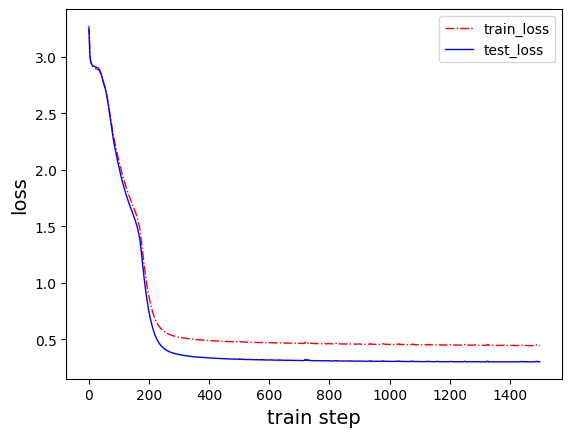

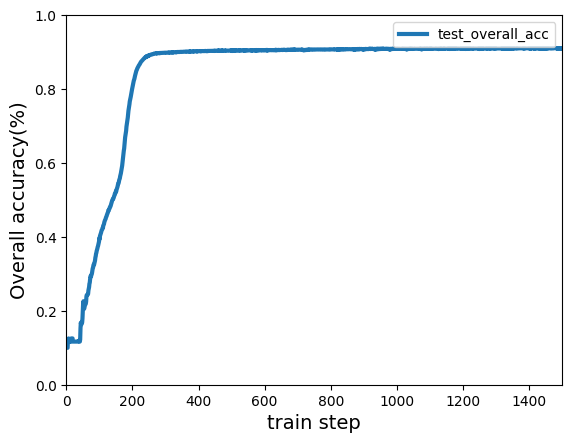

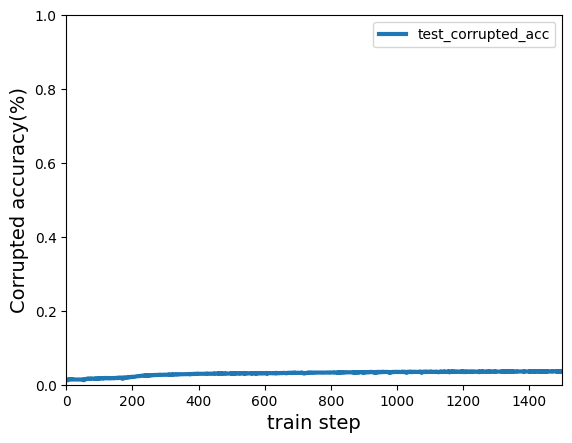

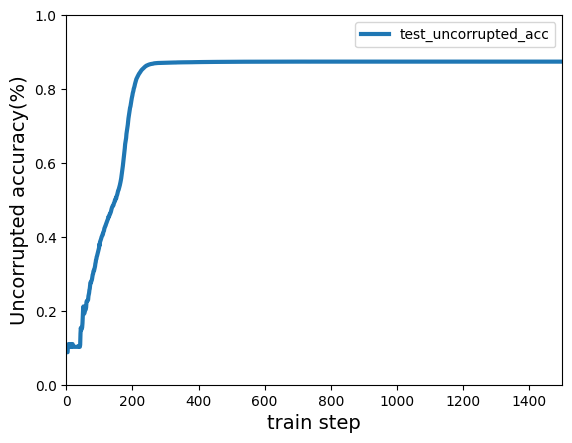


-----------------------------------------------------------------------------------------
Overall accuracy top examples: 

Original Message encrypted: XBHBKMUD-PVVVO-PMCDYPA-LK-OVGLHH
Message decrypted: IDONTKNOWWHETHERTOMWILLSWIMORNOT
Prediction Message decrypted: IDONTKNOWWHETHERTOMWILLSWIMORNOT
Prediction Message Accuracy : 1.0
Original Message encrypted: NCLHVTKPWBGROV--RSJ-KPWMVRPADBT-
Message decrypted: YESTERDAYISAMOREYESTDAYTHANTODAY
Prediction Message decrypted: YESTERDAYISAMOREYESTDAYTHANTODAY
Prediction Message Accuracy : 1.0
Original Message encrypted: XBHBKVOXLD-JJV-JWOKVLCBM-RVLK-GH
Message decrypted: IDONTTHINKISHOULDATTENDTHATEVENT
Prediction Message decrypted: IDONTTHINKISHOULDATTENDTHATEVENT
Prediction Message Accuracy : 1.0

-----------------------------------------------------------------------------------------
Corrupted accuracy top examples: 

Original Message encrypted: XBHBKMUD-PVVVO-PMCDYPA-LK-OVGLHH
Message decrypted: IDONTKNOWWHETHERTOMWILLSWIMORNOT
Predict

In [ ]:
# EVALUATION

# LOSS
plt.plot(loss_hist, '-.r', linewidth=1.0, label='train_loss')
plt.plot(test_loss_hist,'-b', linewidth=1.0, label='test_loss')
plt.xlabel('train step', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend()
plt.show()

# OVERALL ACCURACY
plt.plot(overall_acc_hist, linewidth=3.0, label='test_overall_acc')
plt.xlabel('train step', fontsize=14)
plt.ylabel('Overall accuracy(%)', fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()

# CORRUPTED ACCURACY
plt.plot(corrupted_acc_hist, linewidth=3.0, label='test_corrupted_acc')
plt.xlabel('train step', fontsize=14)
plt.ylabel('Corrupted accuracy(%)', fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()

# UNCORRUPTED ACCURACY
plt.plot(uncorrupted_acc_hist, linewidth=3.0, label='test_uncorrupted_acc')
plt.xlabel('train step', fontsize=14)
plt.ylabel('Uncorrupted accuracy(%)', fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()

decrypter_network = decrypter_network.cpu()

overall_accuracies = []
corrupted_accuracies = []
uncorrupted_accuracies = []
corruption_tensor = torch.tensor([26]*len(test[0][1]))

for idx_sample in range(0,2000):
  # Inference over single training sequence
  letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0))
  # get index of letter with max probability 
  _,maxprob_letters_idx = letters_probs.max(dim=2)
  
  # Accuracy per sample computation
  overall_acc = (1.0*(maxprob_letters_idx[0]==test[idx_sample][1])).mean().item() 
  corrupted_acc = (1.0*torch.logical_and(test[idx_sample][0] == corruption_tensor, maxprob_letters_idx[0]==test[idx_sample][1])).mean().item()
  uncorrupted_acc = (1.0*torch.logical_and(test[idx_sample][0] != corruption_tensor, maxprob_letters_idx[0]==test[idx_sample][1])).mean().item()
  overall_accuracies.append([overall_acc,idx_sample])
  corrupted_accuracies.append([corrupted_acc,idx_sample])
  uncorrupted_accuracies.append([uncorrupted_acc,idx_sample])

# Descending order
overall_accuracies = sorted(overall_accuracies, reverse = True)
corrupted_accuracies = sorted(corrupted_accuracies, reverse = True)
uncorrupted_accuracies = sorted(uncorrupted_accuracies, reverse = True)


N = 3 # Number of examples

# Print the top N accuracies of each type
print("\n-----------------------------------------------------------------------------------------")
print("Overall accuracy top examples: \n")
topN_overall = overall_accuracies[0:N]
for i in range(N):
  idx_sample = topN_overall[i][1]
  overall_acc = topN_overall[i][0]
  # Inference over single training sequence
  letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0))
  # get index of letter with max probability 
  _,maxprob_letters_idx = letters_probs.max(dim=2)
  print(f'Original Message encrypted: {decode_message(test[idx_sample][0],vocabulary)}')
  print(f'Message decrypted: {decode_message(test[idx_sample][1],vocabulary)}')
  print(f'Prediction Message decrypted: {decode_message(maxprob_letters_idx[0],vocabulary)}')
  print(f'Prediction Message Accuracy : {round(overall_acc,2)}')

topN_corrupted = corrupted_accuracies[0:N]
print("\n-----------------------------------------------------------------------------------------")
print("Corrupted accuracy top examples: \n")
for i in range(N):
  idx_sample = topN_corrupted[i][1]
  overall_acc = topN_corrupted[i][0]
  # Inference over single training sequence
  letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0))
  # get index of letter with max probability 
  _,maxprob_letters_idx = letters_probs.max(dim=2)
  print(f'Original Message encrypted: {decode_message(test[idx_sample][0],vocabulary)}')
  print(f'Message decrypted: {decode_message(test[idx_sample][1],vocabulary)}')
  print(f'Prediction Message decrypted: {decode_message(maxprob_letters_idx[0],vocabulary)}')
  print(f'Prediction Corrupted Message Accuracy : {round(overall_acc,2)}')

print("\n-----------------------------------------------------------------------------------------")
print("Uncorrupted accuracy top examples: \n")
topN_uncorrupted = uncorrupted_accuracies[0:N]
for i in range(N):
  idx_sample = topN_uncorrupted[i][1]
  overall_acc = topN_uncorrupted[i][0]
  # Inference over single training sequence
  letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0))
  # get index of letter with max probability 
  _,maxprob_letters_idx = letters_probs.max(dim=2)
  print(f'Original Message encrypted: {decode_message(test[idx_sample][0],vocabulary)}')
  print(f'Message decrypted: {decode_message(test[idx_sample][1],vocabulary)}')
  print(f'Prediction Message decrypted: {decode_message(maxprob_letters_idx[0],vocabulary)}')
  print(f'Prediction Message Uncorrupted Accuracy : {round(overall_acc,2)}')